In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 12 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='M',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 6

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 1832.6674 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-31,146.292435,144.227432,141.458542,136.714539
AAPL,2023-02-28,142.841675,145.345200,145.446686,142.094681
AAPL,2023-03-31,141.337265,146.462967,147.355865,141.603806
AAPL,2023-04-30,142.535858,147.580734,146.932404,141.959457
AAPL,2023-05-31,140.463028,148.698502,143.112061,144.984680


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
        mae          mse      mape       rmse     smape:
0  30.74914  1263.442115  0.168243  35.544931  18.885614

Model: AutoETS
         mae        mse      mape       rmse     smape:
0  26.809143  946.80872  0.146952  30.770257  16.208048

Model: AutoTheta
         mae          mse      mape       rmse     smape:
0  28.285291  1049.673112  0.155285  32.398659  17.210222

Model: CES
         mae          mse      mape       rmse     smape:
0  30.427109  1090.728804  0.169386  33.026184  18.736332

Results for MSFT:
Model: AutoARIMA
         mae          mse      mape       rmse     smape:
0  67.641327  5741.884149  0.211231  75.775221  24.264594

Model: AutoETS
        mae          mse      mape       rmse     smape:
0  56.58754  4082.635638  0.176257  63.895506  19.806992

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  63.646355  4898.04846  0.199913  69.986059  22.653099

Model: CES
         mae          mse      mape

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=6, n_windows=3, step_size=6, level=[99])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2021-08-01,2021-07-01,149.278564,146.628677,139.356995,153.900375,143.434830,100.408546,186.461121,149.235413,141.925217,156.694351,147.177612,135.464249,159.213409
AAPL,2021-09-01,2021-07-01,139.330643,147.807999,136.229141,159.386841,143.461655,82.401718,204.521576,140.035095,129.922470,151.149673,148.665833,136.411362,161.231964
AAPL,2021-10-01,2021-07-01,147.503387,151.455826,137.869125,165.042511,143.488464,68.442528,218.534409,144.875275,132.153122,157.834732,152.117325,140.195908,164.519608
AAPL,2021-11-01,2021-07-01,162.765747,158.080627,143.013550,173.147690,143.515289,56.553448,230.477112,145.480453,129.490250,162.532532,154.867447,142.193481,166.598877
AAPL,2021-12-01,2021-07-01,175.102798,165.635559,148.820282,182.450851,143.542099,45.971161,241.113037,142.188721,124.706230,157.275772,158.478317,146.009644,170.539627


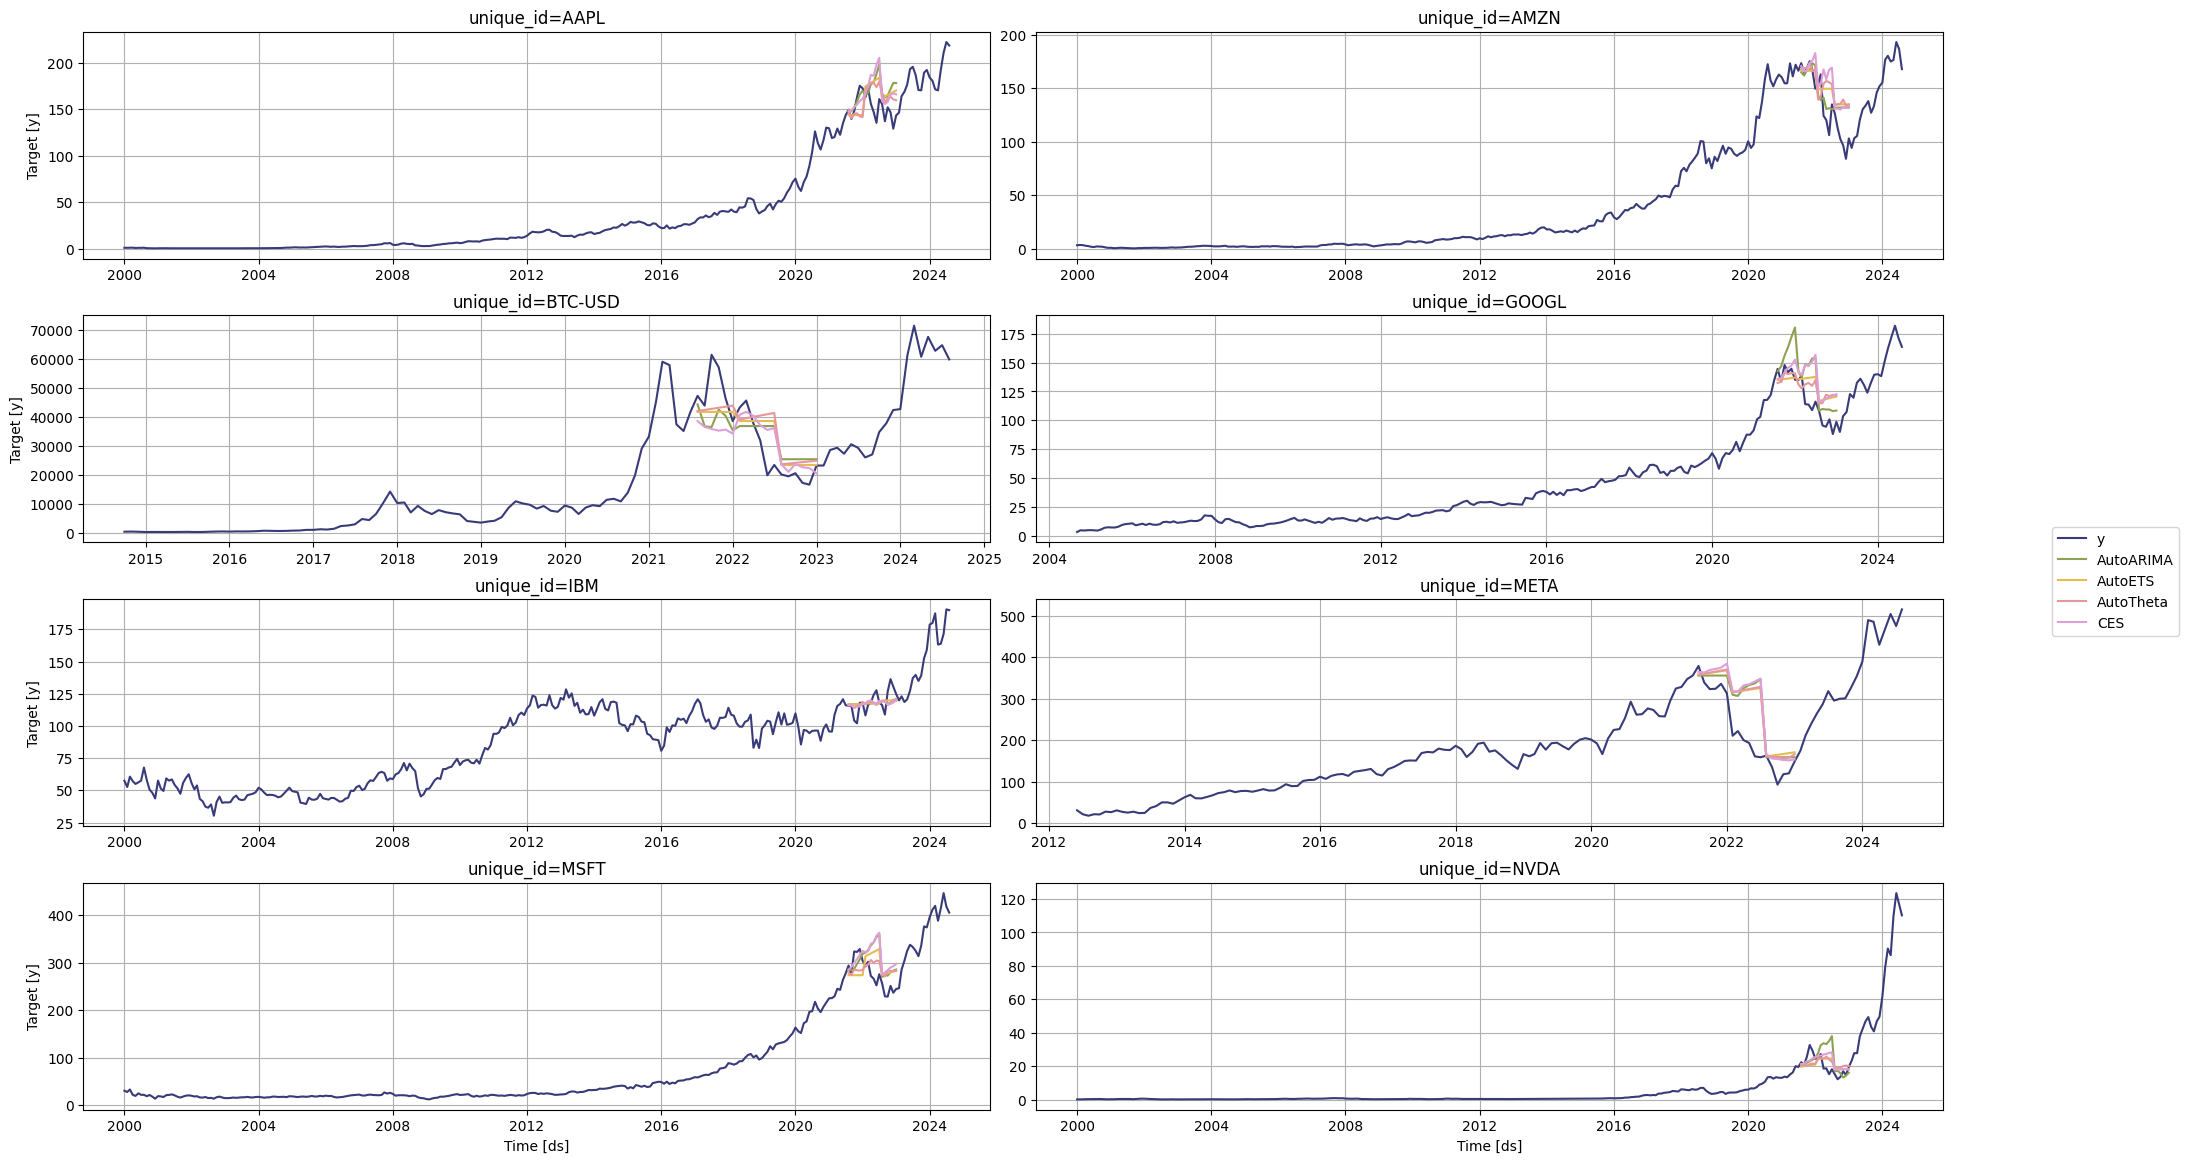

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))